**Проект: Диагностика психического здоровья с объяснимым ИИ (Attention & LIME)**

**Цель**: Обучить модель глубокого обучения на датасете "Reddit Mental Health Data" для классификации текстовых сообщений, связанных с психическим здоровьем. Важной задачей является не только точность предсказаний, но и способность объяснить, как модель пришла к своему решению. Проект направлен на демонстрацию работы механизмов внимания (Attention Mechanism) для внутренней объяснимости и фреймворка LIME (Local Interpretable Model-agnostic Explanations) для внешней постхок-объяснимости, что позволит понять, как модель определяет различные состояния.

Библиотека **LIME**, которая необходима для получения локальных интерпретируемых объяснений для предсказаний модели и **tensorflow** для машинного обучения.

In [1]:
# Установка зависимостей
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user

In [ ]:
!pip install tf-keras-vis tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.9 MB/s eta 0:00:00


nltk (препроцессинг текста)

tensorflow и tensorflow.keras (построение и обучение модели
)

Слои: Input, Embedding, Bidirectional, LSTM, Attention, GlobalMaxPooling1D и Dense

LIME (показывает, какие слова или фразы внесли наибольший вклад (как положительный, так и отрицательный) в решение модели о присвоении определенного "диагноза")

In [ ]:
# Импортированные библиотеки
import os
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Input, Attention, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import kagglehub
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

Для обучения модели был взят датасет из Kaggle "**Reddit Mental Health Data**"

In [ ]:
path = kagglehub.dataset_download("neelghoshal/reddit-mental-health-data")

file_path = os.path.join(path, os.listdir(path)[0])  # берем первый файл в папке
df = pd.read_csv(file_path)

print("Размер датасета:", df.shape)
print("Распределение классов:\n", df['target'].value_counts())

df.head()

100%|██████████| 1.83M/1.83M [00:00<00:00, 53.1MB/s]

Extracting files...


Размер датасета: (5957, 4)
Распределение классов:
 target
1    1202
3    1201
4    1188
2    1185
0    1181
Name: count, dtype: int64


Unnamed: 0                                               text  \
0           0  Welcome to /r/depression's check-in post - a p...   
1           1  We understand that most people who reply immed...   
2           2  Anyone else just miss physical touch? I crave ...   
3           3  I’m just so ashamed. Everyone and everything f...   
4           4  I really need a friend. I don't even have a si...   

                                               title  target  
0  Regular check-in post, with information about ...       1  
1  Our most-broken and least-understood rules is ...       1  
2  I haven’t been touched, or even hugged, in so ...       1  
3                    Being Depressed is Embarrassing       1  
4  I'm desperate for a friend and to feel loved b...       1

Визуализация распределение постов по скорам:
0 = Stress
1 = Depression
2 = Bipolar disorder
3 = Personality disorder
4 = Anxiety

In [ ]:
df['target'].value_counts()

target
1    1202
3    1201
4    1188
2    1185
0    1181
Name: count, dtype: int64

In [ ]:
# Предобработка текста

nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', str(text))
    text = text.lower()
    words = text.split()
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

df['text_cleaned'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Разделение данных на обучающую и тестовую выборки
- 20% данных пойдут в тестовый набор

In [ ]:
# Разделение данных

X = df['text_cleaned']
y = df['target'].values  # Используем .values для numpy array

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Токенизация и паддинг

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100  # Оптимальная длина для постов
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [ ]:
# Балансировка классов

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Веса классов:", class_weights_dict)

Веса классов: {0: np.float64(1.0084656084656085), 1: np.float64(1.017075773745998), 2: np.float64(0.9784394250513347), 3: np.float64(0.9804526748971193), 4: np.float64(1.017075773745998)}


**Модель BiLSTM + Attention**

С использованием Attention Mask

In [ ]:
# Создание модели BiLSTM + Attention

vocab_size = len(tokenizer.word_index) + 1 # Размер словаря определяется автоматически на основе уникальных слов в предобработанном датасете. Добавление +1 обеспечивает корректную обработку паддинг-токенов.
embedding_dim = 128

inputs = Input(shape=(max_len,))
embedding = Embedding(vocab_size, embedding_dim)(inputs)
lstm_out = Bidirectional(LSTM(64, return_sequences=True))(embedding) # возвращаем последовательность для корректной работы механизма внимания

# Механизм внимания
attention = Attention(name='attention_layer')([lstm_out, lstm_out]) # Механизм внимания интегрирован для внутренней объяснимости, позволяя модели фокусироваться на наиболее релевантных частях текста
merged = GlobalMaxPooling1D()(attention)  # Сворачиваем последовательность

outputs = Dense(5, activation='softmax')(merged) # Выходной слой настроен на 5 классов (количество категорий в задаче)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Adam выбран как оптимизатор, ускоряющий сходимость
# accuracy выбрана как основная метрика оценки
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  2,021,504 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 128)  │     98,816 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 100, 128)  │          0 │ bidirectional[0]… │
│ (Attention)         │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ attention_layer[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │        645 │ global_max_pooli… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,120,965 (8.09 MB)

 Trainable params: 2,120,965 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Обучение модели

history = model.fit(
    X_train_padded,
    y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_padded, y_test),
    class_weight=class_weights_dict
)

Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 32s 185ms/step - accuracy: 0.2392 - loss: 1.5822 - val_accuracy: 0.5185 - val_loss: 1.2236
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 182ms/step - accuracy: 0.6158 - loss: 0.9937 - val_accuracy: 0.6770 - val_loss: 0.8752
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - accuracy: 0.8157 - loss: 0.5367 - val_accuracy: 0.7089 - val_loss: 0.7909
Epoch 4/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.8725 - loss: 0.3558 - val_accuracy: 0.7164 - val_loss: 0.7861
Epoch 5/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 170ms/step - accuracy: 0.9077 - loss: 0.2508 - val_accuracy: 0.7173 - val_loss: 0.8424


In [ ]:
class_names = ['Stress', 'Depression', 'Bipolar', 'Personality', 'Anxiety']

In [ ]:
# Оценка модели

loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.7403 - loss: 0.7686
Test Accuracy: 0.7173


Визуализация механизма внимания

In [ ]:
def visualize_attention(text_sample, true_label=None):
    # предобработка текста
    cleaned_text = preprocess_text(text_sample)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(sequence, maxlen=max_len)

    # извлечение весов внимания
    attention_model = Model(inputs=model.input,
                           outputs=model.get_layer('attention_layer').output)
    attention_weights = attention_model.predict(padded)[0]

    # расчет фактической длины текста и маскирование
    actual_length = min(len(sequence[0]), max_len)


    mask = np.array([i < actual_length for i in range(max_len)])

    masked_weights = attention_weights * mask[:, np.newaxis]

    # вычисление среднего веса внимания
    avg_attention = np.mean(masked_weights, axis=-1)

    # получение фактических токенов и обрезка весов
    tokens = tokenizer.sequences_to_texts(sequence)[0].split()[:actual_length]

    avg_attention = avg_attention[:actual_length]

    # cоздание тепловой карты
    plt.figure(figsize=(len(tokens)*0.8, 3))
    plt.imshow([avg_attention], cmap='viridis', aspect='auto')
    plt.yticks([])
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
    plt.colorbar(label='Attention Weight')

    pred = model.predict(padded)
    pred_class = np.argmax(pred)
    title = f"Predicted: {class_names[pred_class]} ({pred[0][pred_class]:.2f})"
    if true_label is not None:
        title += f" | True: {class_names[true_label]}"
    plt.title(title)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


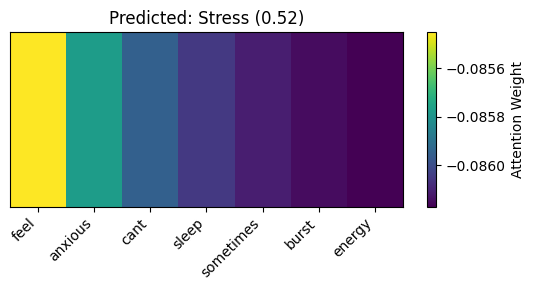

In [ ]:
text = "I feel so anxious and can't sleep, but sometimes I have bursts of energy"
visualize_attention(text)

Входной текст: "I feel so anxious and can't sleep, but sometimes I have bursts of energy"

Предсказание модели: Stress (0.52) - Модель предсказала категорию "Стресс" с вероятностью 52%.

Более светлые (желтые/светло-зеленые) цвета указывают на более высокие веса внимания, а более темные (фиолетовые) — на более низкие.

Наиболее важные слова:

"**anxious**": Это слово имеет самый светлый цвет, что указывает на наивысший вес внимания. Это очень логично, так как "anxious" напрямую связано со стрессом и тревогой. Модель явно сфокусировалась на этом ключевом термине.

"**feel**" : Это слово также имеет относительно светлый цвет, что говорит о высоком внимании. "Feel" указывает на эмоциональное состояние, что также релевантно для определения состояния психического здоровья.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


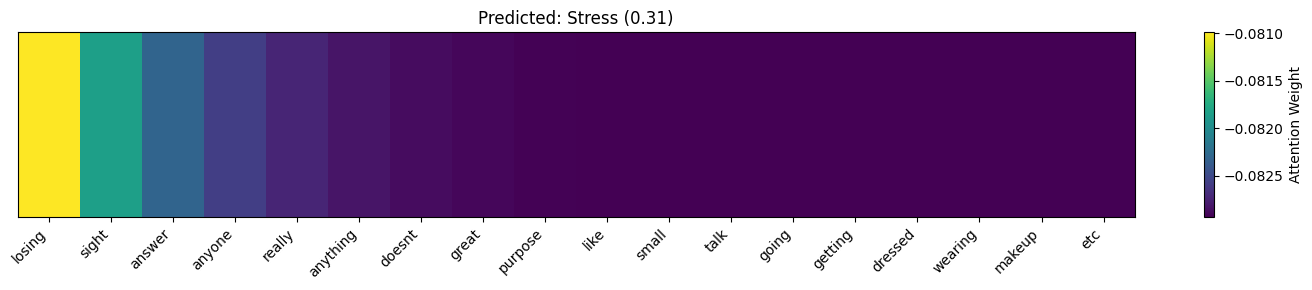

In [ ]:
text = """Losing sight of the answer to why anyone really does anything that doesn’t have great purpose. Like small talk, going out, getting dressed, wearing makeup, etc."""
visualize_attention(text)

Несмотря на то, что вероятность предсказания "Стресс" невысока (0.31), механизм внимания модели все равно сосредотачивается на словах, которые наиболее сильно ассоциируются с негативным состоянием

Теперь посмотрим на конкретный текстовый образец из тестовой выборки

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


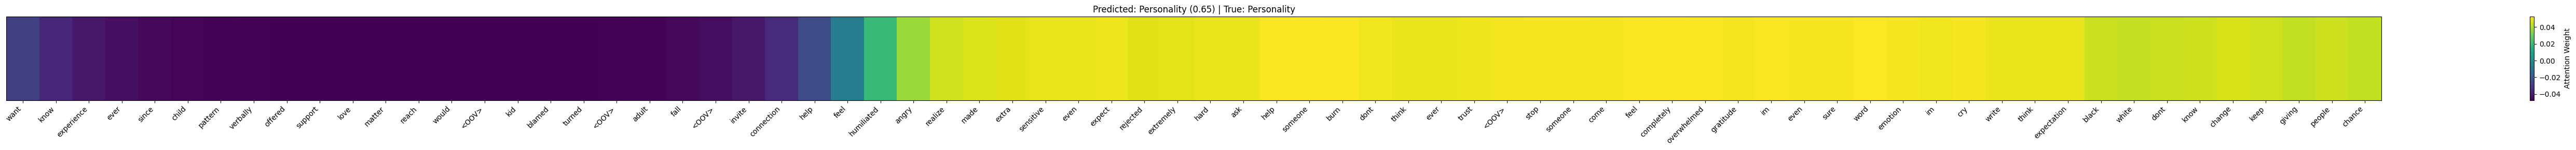

In [ ]:
test_sample = X_test.iloc[10]
true_label = y_test[10]
visualize_attention(test_sample, true_label=true_label)

 Предсказание "Personality" совпадает с истинной меткой, что является хорошим результатом.

 В отличие от предыдущих примеров, где внимание было сосредоточено на нескольких ключевых словах, здесь мы наблюдаем ярко выраженный паттерн распределения внимания по всей длине последовательности. По мере продвижения к концу последовательности, веса внимания плавно и значительно увеличиваются. Это указывает на то, что наиболее важная информация для предсказания находятся в словах в диапазоне от зеленого к желтому.

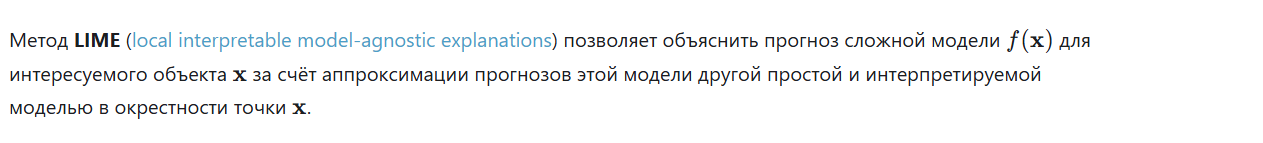

LIME является модельно-независимым (model-agnostic). Это означает, что он внутреннюю структуру модели. Поэтому мы создаем функцию predict_proba, которая принимает текстовые строки и возвращает вероятности предсказаний для каждого класса.

In [ ]:
def predict_proba(texts):
    seq = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(seq, maxlen=max_len)
    return model.predict(padded)

explainer = LimeTextExplainer(class_names=class_names) # Инициализация LimeTextExplainer для генерации объяснений для текстовых данных

In [ ]:
# Пример

text_example = "I feel so anxious and can't sleep, but sometimes I have bursts of energy"
exp = explainer.explain_instance(text_example, predict_proba, num_features=10, top_labels=1)
exp.show_in_notebook(text=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step


Вероятность предсказаний: Модель предсказывает, что наиболее вероятной категорией для данного текста является "Stress" с вероятностью 0.36.
Также показаны вероятности для других классов: "Anxiety" (0.29), "Bipolar" (0.19), "Personality" (0.08), "Depression" (0.07).

Слева от выделенного текста представлен список слов и их численных значений. Эти числа показывают, насколько каждое слово положительно или отрицательно повлияло на предсказание класса "Stress".

In [ ]:
# Пример

text_example = """Losing sight of the answer to why anyone really does anything that doesn’t have great purpose. Like small talk, going out, getting dressed, wearing makeup, etc."""
exp = explainer.explain_instance(text_example, predict_proba, num_features=10, top_labels=1)
exp.show_in_notebook(text=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step


Посмотрим объяснения для каждого из возможных классов предсказания, а не только для наиболее вероятного.

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step

--- Объяснение для класса: Stress ---


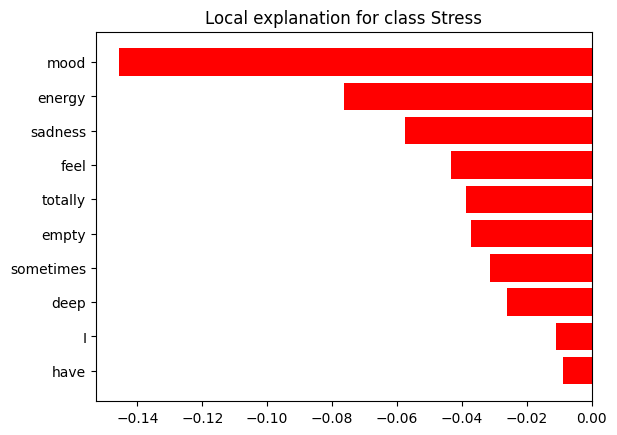

Важные слова для Stress:
mood                 : -0.145
energy               : -0.076
sadness              : -0.057
feel                 : -0.043
totally              : -0.039
empty                : -0.037
sometimes            : -0.031
deep                 : -0.026
I                    : -0.011
have                 : -0.009

--- Объяснение для класса: Depression ---


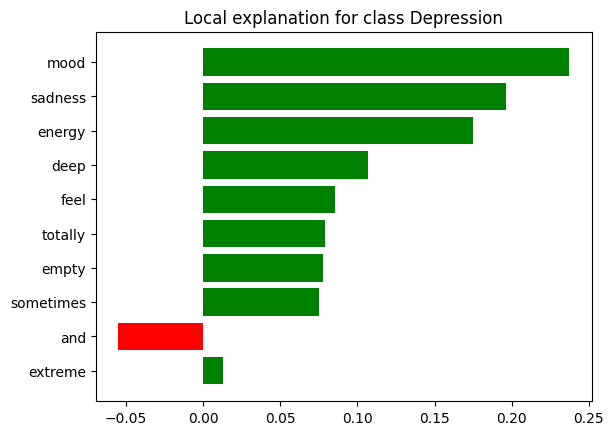

Важные слова для Depression:
mood                 : 0.237
sadness              : 0.196
energy               : 0.175
deep                 : 0.107
feel                 : 0.085
totally              : 0.079
empty                : 0.078
sometimes            : 0.075
and                  : -0.055
extreme              : 0.013

--- Объяснение для класса: Bipolar ---


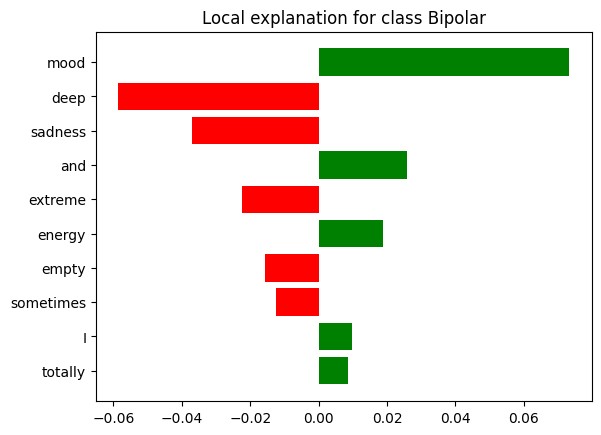

Важные слова для Bipolar:
mood                 : 0.073
deep                 : -0.059
sadness              : -0.037
and                  : 0.026
extreme              : -0.022
energy               : 0.019
empty                : -0.016
sometimes            : -0.012
I                    : 0.010
totally              : 0.009

--- Объяснение для класса: Personality ---


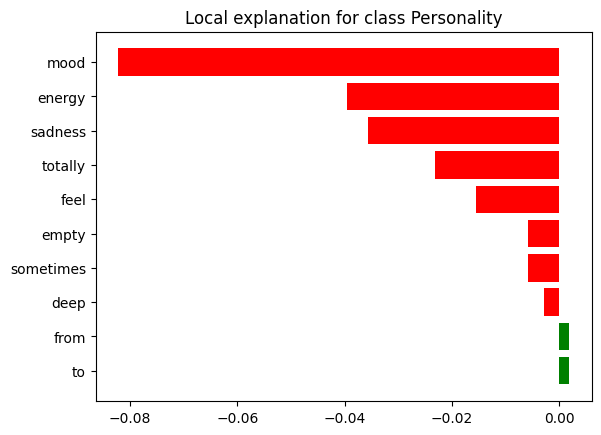

Важные слова для Personality:
mood                 : -0.082
energy               : -0.040
sadness              : -0.036
totally              : -0.023
feel                 : -0.015
empty                : -0.006
sometimes            : -0.006
deep                 : -0.003
from                 : 0.002
to                   : 0.002

--- Объяснение для класса: Anxiety ---


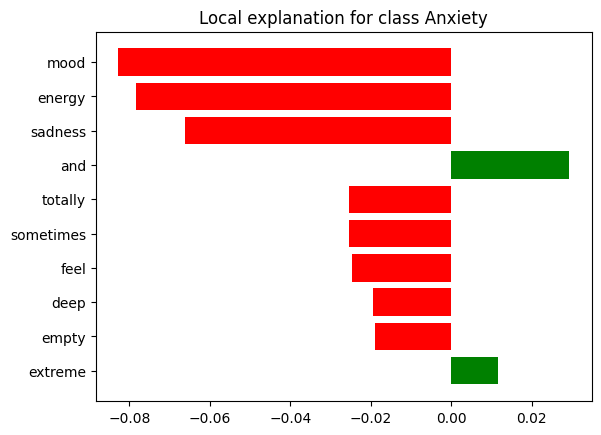

Важные слова для Anxiety:
mood                 : -0.083
energy               : -0.078
sadness              : -0.066
and                  : 0.029
totally              : -0.025
sometimes            : -0.025
feel                 : -0.025
deep                 : -0.019
empty                : -0.019
extreme              : 0.012


In [ ]:
# Выбираем пример текста
sample_text = "I have mood swings from extreme energy to deep sadness and sometimes feel totally empty"

# Генерируем объяснения для ВСЕХ классов
exp = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10,
    top_labels=5  # Показываем все 5 классов
)

# Визуализация для каждого класса
for i in range(len(class_names)):
    print(f"\n--- Объяснение для класса: {class_names[i]} ---")
    exp.as_pyplot_figure(label=i)
    plt.show()

    # Альтернативный текстовый вывод
    print(f"Важные слова для {class_names[i]}:")
    for feature, weight in exp.as_list(label=i):
        print(f"{feature:20} : {weight:.3f}")

In [ ]:
Благодаря такому подходу, на одном и том же тестовом примере мы получаем возможность не только анализировать вклад каждого слова в предсказание конкретного класса, но и понимать относительную "близость" или "дальность" между различными классами.

Этот код объединяет два метода интерпретируемости: LIME и attention mapping.


Визуализация attention: функция visualize_attention создаёт heat map, показывающую слова, на которых модель фокусируется при прогнозировании.

LIME Explainer: локальные объяснения генерируются с помощью LimeTextExplainer, показывая ключевые слова и вклады, которые влияют на каждый результат прогноза.

Attention mapping раскрывает внутреннюю направленность модели, а LIME обеспечивает понятную человеку значимость признаков. Сочетание этих двух факторов повышает доверие.

1. В рамках этого проекта была создана модель классификации текста на основе BiLSTM+Attention для выявления проблем психического здоровья в сообщениях пользователей, а также инновационно интегрированная визуализация attention mapping и интерпретатор LIME для достижения двойной интерпретируемости от внутренней логики модели до основы локальных прогнозов.

2. Используя attention heat map для отображения влияния контекста ключевых слов и используя весовые коэффициенты характеристик LIME для количественной оценки вклада словарного запаса, можно проверить согласованность решений ИИ и клинической семантики, а также повысить прозрачность модели.

3. Результаты проекта могут помочь психологам быстро находить сигналы риска в текстах пациентов, и предоставить определенную справочную ценность для исследования интерпретируемости сложных моделей NLP.